I learned two pretty important things in the past few days about modeling these data. The first is that I've always misunderstood the difference between normalization and standardization. http://stats.stackexchange.com/questions/10289/whats-the-difference-between-normalization-and-standardization In a few words, normalization puts a feature/column/variable into a fixed range (between 0 and 1), without much regard for the overall distribution. Standardization, by contrast, transforms each value so that the new value reflects how far the old value deviated from the mean (i.e. it respects the distribution).

In my previous post about LDA and cross-validation, I normalized instead of standardizing, which put both of my variables on the same scale, but lost a great deal of information about the distribution in the process. What I actually wanted to do was standardize, so that both variables were mean-centered and proportional to the standard deviation(s). Luckily, there is a standardizer function built into the same package that I used to normalize. Let's start there.

In [1]:
from dissdata import importation
from sklearn import cross_validation, preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# This gets ahold of the data through a custom importation class I wrote
exp = importation()

feat_col = exp.exp[1][['onset_dur','object_dur']]
# This nifty function from scikit's preprocessing standardizes all of the columns
X = preprocessing.StandardScaler().fit_transform(feat_col)
# Then this guy converts a column of string-type categories (identical, control,
# related, unrelated) into a more-usable set of categorical integers.
labeler = preprocessing.LabelEncoder().fit(exp.exp[1]['condition'])
y = labeler.transform(exp.exp[1]['condition']) + 1

We've seen the next bit before, and will see it many times again, but it's still worth pointing out how valuable cross-validation is. I increased the ratio of test to train sets this time, just to see. Many of the examples I see around the internet use 80% of their data as training, and only 20% to test. 

In [2]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = .65, random_state = 1)

Now that we have some subsets, let's fit a couple different models this time - both a linear and a quadratic discriminant analysis. My understanding of the difference is that the quadratic analysis projects the data into a higher dimensionality (i.e. X squared), which allows the model to more flexibly discover category boundaries. In this case, it can use parabolas instead of simple hyperplanes. We'll see more of that in a moment.

In [35]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(X_train,y_train)
lda.predict(X_test)
lda.score(X_test,y_test)

0.39157655093910076

This is a wildly more-successful model than in the previous post, which had approximately chance-level success. 40% predictive success still isn't great, but if I were right 15% of the time more frequently than chance in Vegas, they'd throw me out.

We can do the same multiple-validation as last time, and test across several randomly-chosen divisions of the data:

In [36]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(X_train,y_train)
cvthing = cross_validation.ShuffleSplit(y.shape[0], n_iter = 20, test_size = .35)
scores = cross_validation.cross_val_score(lda,X,y,cv = cvthing)
scores.mean()

0.39460887949260043

The original division seems to have been quite close to the average. Question for anyone with more knowledge about this than I have: Sometimes I get a warning when I execute this code that says "The priors do not sum to 1. Renormalizing." I don't fully understand what that means, apart from a vague conceptual understanding. Help?

Regardless, I've been talking about different approaches to boundaries in classification, and here's my first Quadratic Discriminant Analysis. The code is almost identical (which can be dangerous), but produces slightly improved accuracy. Below that, though, the plot of the classification boundaries make it clear that this classifier isn't really doing a good job either.

In [3]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train,y_train)
scores = cross_validation.cross_val_score(qda,X,y,cv = 12)
scores.mean()

0.40347319523161834

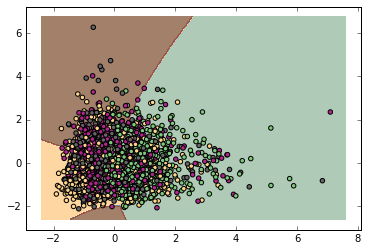

In [38]:
# You can check my previous posts for a more in-depth
# explanation of how this code works
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5


xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Accent, alpha=0.8)
plt.scatter(X[:,0],X[:,1], c = y, cmap = plt.cm.Accent)

It correctly identifies that more of the green dots fall into the green region together, and that most of the light-brown dots hang out in the lower-left, but pink gets almost no play at all. More than anything, the effective absence of a pink region of classification makes this a very poor classifier. Guessing Not-Pink in response to a biased dataset would make a reasonable amount of sense, but pink points make up approximately 25% of the data here. That's a very sizeable chunk to ignore.

What this tells me is that either these data overlap too closely to be accurately classified, or that I still haven't chosen the right type of classifier. If the data points effectively form fewer than four categories, the algorithm might be having a difficult time forcing some points into the fourth. However, a visual inspection tells me that there is some pattern or other here, even if it's hard to nail down firmly.

Does anyone with more experience with this type of classifier have any useful thoughts or suggestions?